In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

In [2]:
sheet_url = 'https://docs.google.com/spreadsheets/d/1Hsmqphn9kGqWa88aYnimQxOvdV7ulv_jeIj0SYeBr3s/edit#gid=0'
csv_export_url = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')
df = pd.read_csv(csv_export_url)

In [3]:
df.head(10)

,home,away,date,p_home,year
0,Winnipeg Jets,Toronto Maple Leafs,4-Oct,0.5284,2017
1,Pittsburgh Penguins,St. Louis Blues,4-Oct,0.6275,2017
2,Edmonton Oilers,Calgary Flames,4-Oct,0.5900,2017
3,San Jose Sharks,Philadelphia Flyers,4-Oct,0.5810,2017
4,Boston Bruins,Nashville Predators,5-Oct,0.5196,2017
5,Buffalo Sabres,Montreal Canadiens,5-Oct,0.4621,2017
6,New York Rangers,Colorado Avalanche,5-Oct,0.6512,2017
7,Ottawa Senators,Washington Capitals,5-Oct,0.4433,2017
8,Detroit Red Wings,Minnesota Wild,5-Oct,0.4376,2017
9,Chicago Blackhawks,Pittsburgh Penguins,5-Oct,0.5586,2017


In [4]:
df['date'] = df['date'].str.upper() + '-' + df['year'].map(str) 
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'home', 'away', 'p_home']]
df.head(10)

,date,home,away,p_home
0,2017-10-04,Winnipeg Jets,Toronto Maple Leafs,0.5284
1,2017-10-04,Pittsburgh Penguins,St. Louis Blues,0.6275
2,2017-10-04,Edmonton Oilers,Calgary Flames,0.5900
3,2017-10-04,San Jose Sharks,Philadelphia Flyers,0.5810
4,2017-10-05,Boston Bruins,Nashville Predators,0.5196
5,2017-10-05,Buffalo Sabres,Montreal Canadiens,0.4621
6,2017-10-05,New York Rangers,Colorado Avalanche,0.6512
7,2017-10-05,Ottawa Senators,Washington Capitals,0.4433
8,2017-10-05,Detroit Red Wings,Minnesota Wild,0.4376
9,2017-10-05,Chicago Blackhawks,Pittsburgh Penguins,0.5586


In [5]:
df['week'] = (np.floor((df['date'] - df['date'][0])/np.timedelta64(1, 'W'))).astype('int') + 1

In [6]:
Teams =  sorted(list(df['home'].unique()))

In [7]:
nweeks = max(df['week']) + 1

In [8]:
n = len(df)
n

1271

In [9]:
X = np.zeros((len(Teams), df.shape[0]))

In [10]:
for i in range(0, df.shape[0]):
    X[Teams.index(df.loc[i, 'home']), i ] = 1
    X[Teams.index(df.loc[i, 'away']), i] = -1

In [11]:
import pystan

In [12]:
def logit(p):
    return np.log(p/(1-p))

In [13]:
y = logit(df['p_home'])

In [14]:
w = df['week'] 

In [15]:
nteams = len(Teams)

In [16]:
data = """
data {
    int<lower=0> n;
    int<lower=0> nweeks;
    int<lower=0> nteams;
    int<lower=0> w[n];
    vector[n] y;
    matrix[nteams, n] X;
}
"""

In [17]:
parameters = """
parameters {
    real<lower = 0, upper=1> gammaWeek;
    real<lower = 0> tauSeason;
    real<lower = 0> tauWeek;
    real<lower = 0> tauGame;
    real alpha;
    matrix[nweeks, nteams] theta;
}
"""

In [18]:
transformed_params = """
transformed parameters {
    vector[n] mu;
    for (i in 1:n) {
        mu[i] <- alpha + theta[w[i],:] * X[:,i];
    }
 }
"""

In [19]:
model = """
model { 
    alpha ~ normal(0, 1);
    gammaWeek ~ uniform(0, 1.5);
    tauSeason ~ uniform(0, 1000);
    tauWeek ~ uniform(0, 1000);
    tauGame ~ uniform(0, 1000);
    y ~ normal(mu, tauGame);
    
    for (j in 1:nteams){
        theta[1,j] ~ normal(0, tauSeason);
    }
    
    for (www in 2:nweeks) {  
        for (j in 1:nteams) {
            theta[www,j] ~ normal(gammaWeek*theta[www-1,j], tauWeek);
          }
  
     }
    }
"""

In [20]:
model_data = {'n': n,
              'nweeks' : nweeks, 
              'nteams' : nteams,
              'w' : w,
              'y' : y,
              'X': X}

fit = pystan.stan(model_code=data + parameters + transformed_params + model, data=model_data, iter=3000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ef07199f174808b6e84b0d5f7f1adb59 NOW.


In [21]:
sample = fit.extract(permuted=True)

In [22]:
sample['gammaWeek'].T.mean()

0.9936799784691496

In [23]:
sample['alpha'].T.mean()

0.20875427523084317

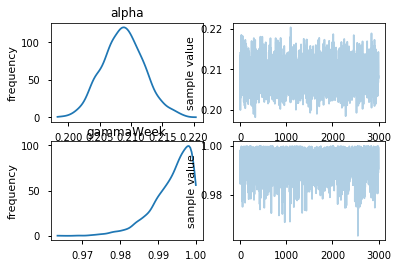

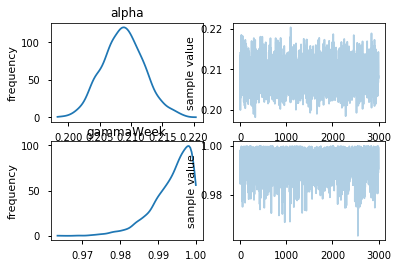

In [24]:
fit.plot(pars = ['alpha', 'gammaWeek'])

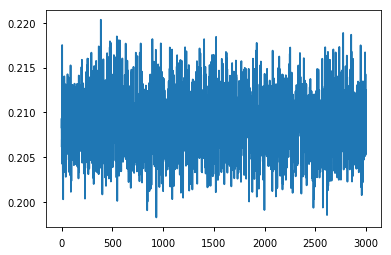

In [25]:
plt.plot(sample['alpha'])

In [26]:
sample['theta'].shape

(3000, 28, 31)

In [27]:
sample['theta'][:, :, 1].mean(axis = 0)

array([-0.24567202, -0.29468993, -0.32479844, -0.33972087, -0.36690494,
       -0.34840601, -0.35995944, -0.35480148, -0.35365628, -0.36302277,
       -0.38808968, -0.4136821 , -0.42324846, -0.40331869, -0.38044073,
       -0.34607523, -0.34959043, -0.35170639, -0.38263847, -0.38419787,
       -0.36512552, -0.3628984 , -0.35892762, -0.35328286, -0.34077476,
       -0.29707597, -0.26316296, -0.26223588])

In [28]:
Teams

['Anaheim Ducks',
 'Arizona Coyotes',
 'Boston Bruins',
 'Buffalo Sabres',
 'Calgary Flames',
 'Carolina Hurricanes',
 'Chicago Blackhawks',
 'Colorado Avalanche',
 'Columbus Blue Jackets',
 'Dallas Stars',
 'Detroit Red Wings',
 'Edmonton Oilers',
 'Florida Panthers',
 'Los Angeles Kings',
 'Minnesota Wild',
 'Montreal Canadiens',
 'Nashville Predators',
 'New Jersey Devils',
 'New York Islanders',
 'New York Rangers',
 'Ottawa Senators',
 'Philadelphia Flyers',
 'Pittsburgh Penguins',
 'San Jose Sharks',
 'St. Louis Blues',
 'Tampa Bay Lightning',
 'Toronto Maple Leafs',
 'Vancouver Canucks',
 'Vegas Golden Knights',
 'Washington Capitals',
 'Winnipeg Jets']

In [29]:
l = ['Carolina Hurricanes', 'Philadelphia Flyers', 'Pittsburgh Penguins', 'Colorado Avalanche', 'Vegas Golden Knights']

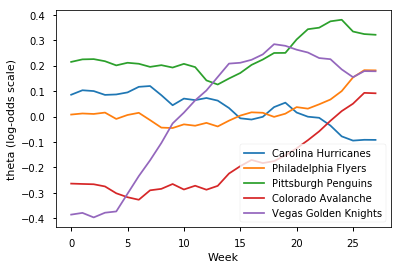

In [30]:
for i in l:
    id = Teams.index(i)
    plt.plot(sample['theta'][:, :, id].mean(axis = 0))
    plt.xlabel('Week')
    plt.ylabel('theta (log-odds scale)')
    plt.legend(l)

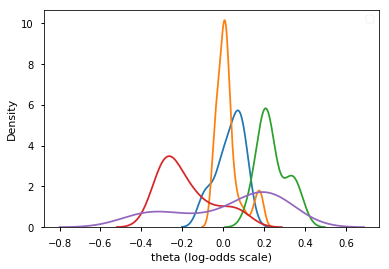

In [31]:
import seaborn as sns
for i in l:
    id = Teams.index(i)
    sns.kdeplot((sample['theta'][:, :, id].mean(axis = 0)))
    plt.xlabel('theta (log-odds scale)')
    plt.ylabel('Density')
    plt.legend(l)

In [72]:
d = {'team_id': l[1], 'beta': sample['theta'][:, :, Teams.index(l[1])]}
team_1 = pd.DataFrame.from_dict(data = [d])
d2 = {'team_id': l[2], 'beta': sample['theta'][:, :, Teams.index(l[2])]}
team_2 = pd.DataFrame.from_dict(data = [d2])

In [107]:
do_penguins_win = []
for i in range(10000):
    flyers_strength = np.random.choice(team_1['beta'][0].mean(axis = 1), 7)
    penguins_strength = np.random.choice(team_2['beta'][0].mean(axis = 1), 7)
    home_adv = np.random.choice(sample['alpha'], 7)

    logit_games = penguins_strength - flyers_strength + home_adv*[1, 1, -1, -1, 1, -1, 1]

    prob_games = np.exp(logit_games)/(1 + np.exp(logit_games))
    penguins_wins = np.random.binomial(1, prob_games, 7)

    do_penguins_win.append(sum(penguins_wins) >= 4)

sum(do_penguins_win)/10000

0.637